In [26]:
#IMPORTS
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline
pd.options.display.float_format = '{:,.0f}'.format


In [13]:
#  IMPORT FROM CSV, PREPROCESSING


df = pd.read_csv('clean_data/data_set_CLEAN.csv')
features = df.columns
# Define the order of categories
energy_class_order = ['A+', 'A', 'B', 'C', 'D', 'E', 'F']

# Convert the "Energy Class" column to categorical with the specified order
df['Energy class'] = pd.Categorical(df['Energy class'], categories=energy_class_order, ordered=True)

df['price_sqm'] = df['Price (euro)'] / df['Living surface (sqm)']

def province(dfval):
    postal_codes = [range(1000,1300), range(1300, 1500), range(1500,1990), range(3000,3500), range(2000,3000), range(3500,4000), range(4000,5000), range(5000,6000), range(6000,6600), range(7000,8000), range(6600,7000), range(8000,9000), range(9000,10000)]
    provinces = ['Brussels Hoofdstedelijk Gewest', 'Waals-Brabant', 'Vlaams-Brabant', 'Vlaams-Brabant', 'Antwerpen', 'Limburg', 'Luik', 'Namen','Henegouwen', 'Henegouwen','Luxemburg', 'West-Vlaanderen', 'Oost-Vlaanderen']
    
    for pc_range, prov in zip(postal_codes, provinces):
        if dfval in pc_range:
            return prov

df['province'] = df['Postal code'].apply(lambda x: province(x))


def region(dfval):
    if dfval in range(1300,1500) or dfval in range(4000,7000):
        return 'Wallonia'
    elif dfval in range(1000,1300):
        return 'Brussels'
    else:
        return 'Flanders'

df['region'] = df['Postal code'].apply(lambda x: region(x))

countrydf = df[['Locality','Postal code','Construction year', 'Price (euro)','Type of property', 'Subtype', 'Energy class', 'Heating type', 'Building condition','province','region','price_sqm']]
countrydf['price_sqm'] = round(countrydf['price_sqm'])
countrydf['Locality'] = countrydf['Locality'].str.capitalize()

numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

def remove_outliers(cols,dfold):
    dfnew = dfold.copy()
    for col in cols:
        Q75 = df[col].quantile(0.75)
        Q25 = df[col].quantile(0.25)
        iqr = Q75- Q25
        upper = Q75 + (1.5 * iqr)
        lower = Q25 - (1.5 * iqr)

        dfnew = dfnew[(dfnew[col] > lower) & (dfnew[col] < upper)]
    
    return dfnew


C:\Users\MKnaepen\AppData\Local\Temp\ipykernel_16448\1831673912.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  countrydf['price_sqm'] = round(countrydf['price_sqm'])
C:\Users\MKnaepen\AppData\Local\Temp\ipykernel_16448\1831673912.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  countrydf['Locality'] = countrydf['Locality'].str.capitalize()


In [14]:
raw = pd.read_csv('raw_data/data_set_RAW.csv')
print(len(raw))
to_remove = ['Price']
uniques = remove_outliers(to_remove,raw)
print(len(uniques))


128


KeyError: 'Price'

Group 1:

Construction year: 24.04%
Building condition boolean: 14.40%
Energy class boolean: 12.31%


Group 2:

Double glazing boolean: 8.62%
Accessible for disabled people boolean: 8.20%
Living surface (sqm): 7.00%


Group 3:

Furnished boolean: 6.20%
Nb of Bedrooms: 5.17%
Bathrooms total nb: 3.03%


Group 4:

Kitchen equipped boolean: 2.51%
Open fire: 2.40%
Number of frontages: 1.91%


Group 5:

Swimming pool boolean: 1.78%
Plot surface (sqm): 1.07%
Terrace surface (sqm): 0.72%


Group 6:

Garden surface (sqm): 0.50%
Parking boolean: 0.14%
Flood safe boolean: 0.00%


Group 7:

Tenement building boolean: 0.00%




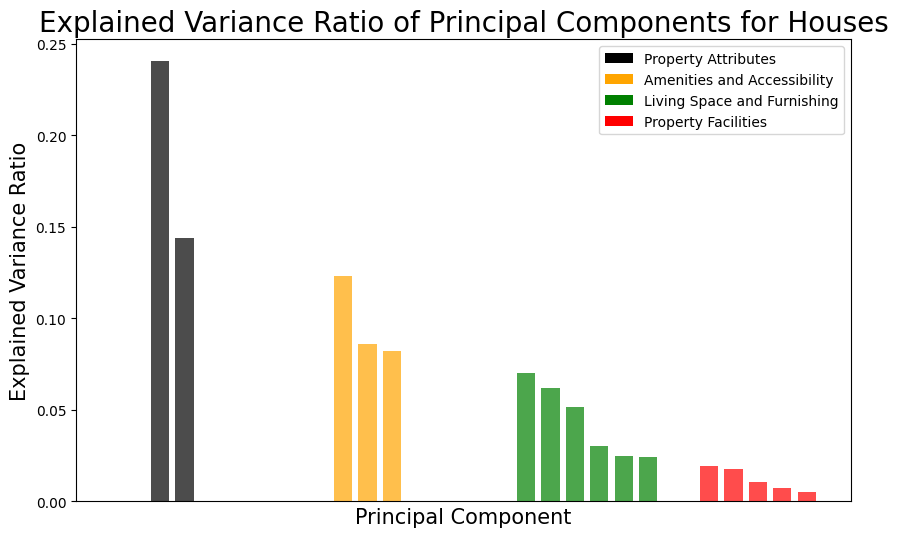

In [ ]:
# PCA FOR HOUSES

# Drop rows with missing values
pcadf = df[df['Type of property'] == 'House']
pcadf = pcadf.dropna()

# Drop specified columns
columns_to_drop = ['Property ID', 'price_sqm', 'Price (euro)', 'Garden boolean', 'Parking tot nb', 'Terrace boolean',
                   'Bathrooms total nb boolean', 'Bathrooms', 'Shower rooms', 'Outdoor parking spaces', 
                   'Covered parking spaces', 'Postal code','Elevator boolean','Energy class','New Construction boolean']
pcadf.drop(columns=columns_to_drop, inplace=True)

# Selecting numerical columns for PCA
numerical_columns = pcadf.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Handling non-numeric values and missing data
numeric_transformer = StandardScaler()

# One-hot encode categorical columns
categorical_columns = []  # No categorical columns now

# Preprocess and transform the data
scaled_data = numeric_transformer.fit_transform(pcadf[numerical_columns])

# Perform PCA
pca = PCA()
pca.fit(scaled_data)

# Fit OneHotEncoder and get feature names
encoder = OneHotEncoder()
encoder.fit(pcadf[categorical_columns])
encoded_column_names = encoder.get_feature_names_out(categorical_columns).tolist()

# Combine column names
column_names = numerical_columns + encoded_column_names

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Extracting column names and their explained variance
variance_explained = [(column_names[i], explained_variance_ratio[i] * 100) for i in range(len(column_names))]

# Change the number of groups
num_groups = 5  # Change the number of groups here

# Reset groupings dictionary
groupings = {}

# Determine the number of features per group
features_per_group = len(variance_explained) // num_groups

# Grouping the column names and their explained variance
for i, (column, variance) in enumerate(variance_explained):
    group_index = i // features_per_group
    group = f'Group {group_index + 1}'
    if group not in groupings:
        groupings[group] = []
    groupings[group].append((column, variance))

# Extract explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Sort the explained variance ratio in descending order
sorted_indices = np.argsort(explained_variance_ratio)[::-1]
explained_variance_ratio_sorted = [explained_variance_ratio[i] for i in sorted_indices]

grouped_indices = [[0,1],[2,3,4],[5,6,7,8,9,10],[11,12,13,14,15]]
# Customizable group names and colors
custom_group_labels = ['Property Attributes', 'Amenities and Accessibility', 'Living Space and Furnishing','Property Facilities']
custom_colors = ['black', 'orange', 'green','red']

plt.figure(figsize=(10, 6))

bar_width = 0.15  # Width of each bar
space_between_bars = 0.05  # Space between bars
space_between_groups = 1.5  # Space between groups

# Plot bars for each group
for i, indices in enumerate(grouped_indices):
    group_label = custom_group_labels[i] if i < len(custom_group_labels) else f'Group {i+1}'
    color = custom_colors[i % len(custom_colors)] if i < len(custom_colors) else 'blue'
    for j, idx in enumerate(indices):
        x_position = i * space_between_groups + j * (bar_width + space_between_bars)
        plt.bar(x_position, explained_variance_ratio[idx], width=bar_width, alpha=0.7, color=color)

# Print the grouped features and their explained variance
for group, columns in groupings.items():
    print(f"{group}:\n")
    for column, variance in columns:
        print(f"{column}: {variance:.2f}%")
    print("\n")

plt.xlabel('Principal Component', fontsize=15)
plt.ylabel('Explained Variance Ratio', fontsize=15)
plt.title('Explained Variance Ratio of Principal Components for Houses', fontsize=20)

# Create legend for groups
group_labels = custom_group_labels[:num_groups]
for i, label in enumerate(group_labels):
    plt.bar(0, 0, color=custom_colors[i % len(custom_colors)], label=label)

plt.legend()

plt.xticks([])

plt.show()



Group 1:

Construction year: 15.61%
Building condition boolean: 10.07%
Energy class boolean: 8.05%
Double glazing boolean: 7.95%


Group 2:

Elevator boolean: 7.19%
Accessible for disabled people boolean: 6.78%
Living surface (sqm): 6.15%
Furnished boolean: 5.64%


Group 3:

Nb of Bedrooms: 5.31%
Bathrooms total nb: 5.16%
Kitchen equipped boolean: 4.79%
Open fire: 4.25%


Group 4:

Number of frontages: 4.00%
Swimming pool boolean: 3.12%
Plot surface (sqm): 2.65%
Terrace surface (sqm): 2.08%


Group 5:

Garden surface (sqm): 1.19%
Parking boolean: 0.00%
Flood safe boolean: 0.00%
Tenement building boolean: 0.00%




C:\Users\MKnaepen\AppData\Local\Temp\ipykernel_20716\1413584192.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\MKnaepen\AppData\Local\Temp\ipykernel_20716\1413584192.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



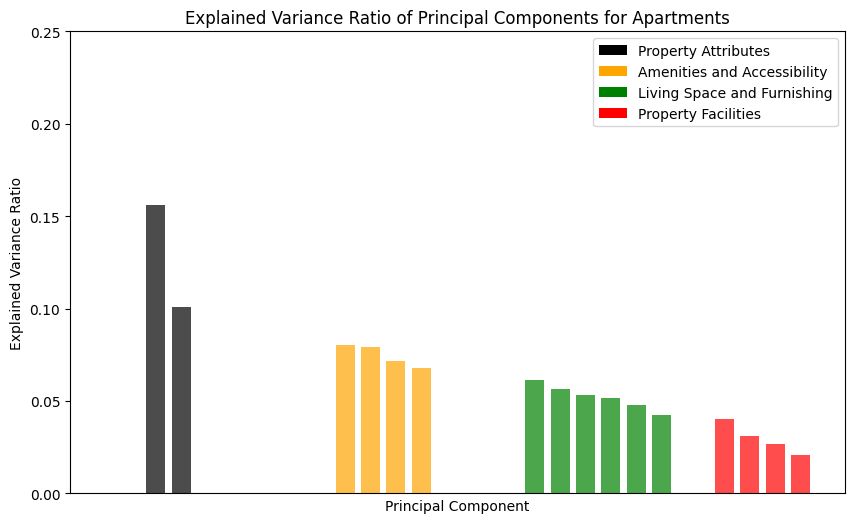

In [ ]:
# PCA FOR APARTMENTS

# Drop rows with missing values
pcadf2 = df[df['Type of property'] == 'Apartment']

numeric_columns = pcadf2.select_dtypes(include=['number']).columns

# fill 0 to all NaN 
pcadf2[numeric_columns] = pcadf2[numeric_columns].fillna(0)

# Drop specified columns
columns_to_drop = ['Property ID', 'price_sqm', 'Price (euro)', 'Garden boolean', 'Parking tot nb', 'Terrace boolean',
                   'Bathrooms total nb boolean', 'Bathrooms', 'Shower rooms', 'Outdoor parking spaces', 
                   'Covered parking spaces', 'Postal code','Energy class', 'New Construction boolean']
pcadf2.drop(columns=columns_to_drop, inplace=True)
pcadf2 = pcadf2.dropna()

# Selecting numerical columns for PCA
numerical_columns = pcadf2.select_dtypes(include=['float64', 'int64']).columns.tolist()


# Handling non-numeric values and missing data
numeric_transformer = StandardScaler()
# One-hot encode categorical columns
categorical_columns = []  # No categorical columns now

# Preprocess and transform the data
scaled_data = numeric_transformer.fit_transform(pcadf2[numerical_columns])

# Perform PCA
pca = PCA()
pca.fit(scaled_data)

# Fit OneHotEncoder and get feature names
encoder = OneHotEncoder()
encoder.fit(pcadf2[categorical_columns])
encoded_column_names = encoder.get_feature_names_out(categorical_columns).tolist()

# Combine column names
column_names = numerical_columns + encoded_column_names

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Extracting column names and their explained variance
variance_explained = [(column_names[i], explained_variance_ratio[i] * 100) for i in range(len(column_names))]

# Change the number of groups
num_groups = 5  # Change the number of groups here

# Reset groupings dictionary
groupings = {}

# Determine the number of features per group
features_per_group = len(variance_explained) // num_groups

# Grouping the column names and their explained variance
for i, (column, variance) in enumerate(variance_explained):
    group_index = i // features_per_group
    group = f'Group {group_index + 1}'
    if group not in groupings:
        groupings[group] = []
    groupings[group].append((column, variance))

# Extract explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Sort the explained variance ratio in descending order
sorted_indices = np.argsort(explained_variance_ratio)[::-1]
explained_variance_ratio_sorted = [explained_variance_ratio[i] for i in sorted_indices]

grouped_indices = [[0,1],[2,3,4,5],[6,7,8,9,10,11],[12,13,14,15]]

# Customizable group names and colors
custom_group_labels = ['Property Attributes', 'Amenities and Accessibility', 'Living Space and Furnishing','Property Facilities']
custom_colors = ['black', 'orange', 'green','red']

plt.figure(figsize=(10, 6))

bar_width = 0.15  # Width of each bar
space_between_bars = 0.05  # Space between bars
space_between_groups = 1.5  # Space between groups

# Plot bars for each group
for i, indices in enumerate(grouped_indices):
    group_label = custom_group_labels[i] if i < len(custom_group_labels) else f'Group {i+1}'
    color = custom_colors[i % len(custom_colors)] if i < len(custom_colors) else 'blue'
    for j, idx in enumerate(indices):
        x_position = i * space_between_groups + j * (bar_width + space_between_bars)
        plt.bar(x_position, explained_variance_ratio[idx], width=bar_width, alpha=0.7, color=color)

# Print the grouped features and their explained variance
for group, columns in groupings.items():
    print(f"{group}:\n")
    for column, variance in columns:
        print(f"{column}: {variance:.2f}%")
    print("\n")

plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio of Principal Components for Apartments')
plt.ylim(0,0.25)

# Create legend for groups
group_labels = custom_group_labels[:num_groups]
for i, label in enumerate(group_labels):
    plt.bar(0, 0, color=custom_colors[i % len(custom_colors)], label=label)

plt.legend()

# Hide x-axis labels
plt.xticks([])

plt.show()




In [ ]:
# FIND CHEAPEST AND MOST EXPENSIVE LOCALITIES
# housedf now contains apartments too
pricedf = df[['Locality', 'Postal code', 'Price (euro)', 'Type of property', 'price_sqm','province']]


# Create a DataFrame with value counts of each postal code
postal_code_counts = pricedf['Postal code'].value_counts().reset_index()
postal_code_counts.columns = ['Postal code', 'Count']

# Filter the postal codes where count is 10 or higher
filtered_postal_codes = postal_code_counts[postal_code_counts['Count'] >= 10]

# Extract the postal codes which satisfy the condition
filtered_postal_codes_list = filtered_postal_codes['Postal code'].tolist()

# Filter the original DataFrame based on these postal codes
filtered_df = df[df['Postal code'].isin(filtered_postal_codes_list)]
print(filtered_df['Postal code'].value_counts())
# Now, filtered_df contains the rows where the 'Postal code' value counts are 10 or higher

housedf = pricedf.sort_values('Price (euro)')
housedf = filtered_df.groupby('Postal code').agg({'Locality': 'first','province':'first', 'Price (euro)': 'mean', 'price_sqm': 'mean' })
# Find the 5 postal codes with the lowest prices
lowestsqm = housedf.nsmallest(5, 'price_sqm').drop(columns='Price (euro)')

# Find the 5 postal codes with the highest prices
highestsqm = housedf.nlargest(7, 'price_sqm').drop(columns='Price (euro)')

print("5 postal codes with the lowest prices for houses:")
display(lowestsqm)

print("\n5 postal codes with the highest prices for houses:")
display(highestsqm)




Postal code
8300    833
9000    472
1000    471
1050    471
1180    446
       ... 
4620     10
6927     10
6031     10
6120     10
1130     10
Name: count, Length: 507, dtype: int64
5 postal codes with the lowest prices for houses:


,Locality,province,price_sqm
Postal code,,,
5660,couvin,Namen,"1,008"
7120,sampzon,Henegouwen,"1,018"
7380,quievrain,Henegouwen,"1,046"
5670,viroinval,Namen,"1,082"
7170,manage-la-hestre,Henegouwen,"1,149"



5 postal codes with the highest prices for houses:


,Locality,province,price_sqm
Postal code,,,
8300,knokke-heist,West-Vlaanderen,"11,393"
8301,heist-aan-zee,West-Vlaanderen,"7,713"
3000,leuven,Vlaams-Brabant,"6,718"
9830,sint-martens-latem,Oost-Vlaanderen,"5,114"
8620,nieuwpoort,West-Vlaanderen,"5,064"
2000,antwerp,Antwerpen,"4,822"
1050,ixelles,Brussels Hoofdstedelijk Gewest,"4,748"


In [ ]:
#FIND ALL BRUSSELS LOCALITIES, SORT BY AVG PRICE PER SQM

pricedf = df[['Locality', 'Postal code', 'Price (euro)', 'Type of property', 'price_sqm','province']]
appartmentdf = pricedf[pricedf['Postal code'].isin(range(1201))]
appartmentdf = appartmentdf.sort_values('Price (euro)')
appartmentdf = appartmentdf.groupby('Postal code').agg({'Locality': 'first','province':'first', 'Price (euro)': 'mean', 'price_sqm': 'mean' })
# Find the 5 postal codes with the lowest prices
lowest_prices = appartmentdf.nsmallest(5, 'Price (euro)').drop(columns='price_sqm')
lowestsqm = appartmentdf.nsmallest(5, 'price_sqm').drop(columns='Price (euro)')

sorteddf = appartmentdf.sort_values('price_sqm', ascending=False)
display(sorteddf)
'''# Find the 5 postal codes with the highest prices
highest_prices = appartmentdf.nlargest(5, 'Price (euro)').drop(columns='price_sqm')
highestsqm = appartmentdf.nlargest(6, 'price_sqm').drop(columns='Price (euro)')

print("5 postal codes with the lowest prices for appartments:")
display(lowest_prices, lowestsqm)

print("\n5 postal codes with the highest prices for appartments:")
display(highest_prices, highestsqm)'''



,Locality,province,Price (euro),price_sqm
Postal code,,,,
1050,ixelles,Brussels Hoofdstedelijk Gewest,"853,923","4,748"
1180,uccle,Brussels Hoofdstedelijk Gewest,"982,041","4,531"
1000,bruxelles,Brussels Hoofdstedelijk Gewest,"687,375","4,406"
1160,auderghem,Brussels Hoofdstedelijk Gewest,"558,180","4,272"
1170,watermael-boitsfort,Brussels Hoofdstedelijk Gewest,"692,341","4,199"
1150,woluwe-saint-pierre,Brussels Hoofdstedelijk Gewest,"819,751","4,143"
1200,woluwe-saint-lambert,Brussels Hoofdstedelijk Gewest,"518,073","4,084"
1040,etterbeek,Brussels Hoofdstedelijk Gewest,"664,865","3,884"
1060,saint-gilles,Brussels Hoofdstedelijk Gewest,"602,496","3,503"


'# Find the 5 postal codes with the highest prices\nhighest_prices = appartmentdf.nlargest(5, \'Price (euro)\').drop(columns=\'price_sqm\')\nhighestsqm = appartmentdf.nlargest(6, \'price_sqm\').drop(columns=\'Price (euro)\')\n\nprint("5 postal codes with the lowest prices for appartments:")\ndisplay(lowest_prices, lowestsqm)\n\nprint("\n5 postal codes with the highest prices for appartments:")\ndisplay(highest_prices, highestsqm)'

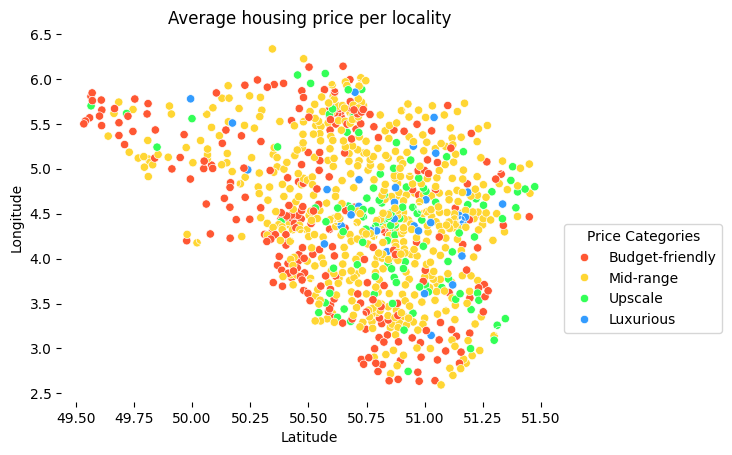

In [ ]:
# COUNTRY GRAPH 
# read merged2.csv because I accidentally deleted that code
merged2 = pd.read_csv('merged2.csv')
PriceCat = pd.cut(merged2['Price (euro)'], bins=[0, 250000, 500000, 750000,  15000000], 
                  labels=[
                            'Budget-friendly',
                            'Mid-range',
                            'Upscale',
                            'Luxurious',
                            
                        ])
df['PriceCat'] = PriceCat
hue_order=['Budget-friendly', 'Mid-range', 'Upscale', 'Luxurious']
sns.scatterplot(data=merged2, x='Lat', y='Long', hue='PriceCat', hue_order=hue_order)
bright_colors = ['#FF5733', '#FFD633', '#33FF57', '#339CFF', '#9C33FF', '#FF33F4', '#33FFF8']
sns.set_palette(bright_colors)
plt.legend(title='Price Categories', loc='best', bbox_to_anchor=(1, 0.5))
sns.despine(bottom = True, left = True)
plt.title('Average housing price per locality')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()


In [17]:
# SIMPLE REGRESSION ANALYSIS FOR HOUSE AND APARTMENT COMBINED

# Combine the datasets
combined_df = df

# Separate features (X) and target variable (y)

X = combined_df.drop(columns=['Price (euro)'], errors='ignore')
y = combined_df['Price (euro)'].fillna(combined_df['Price (euro)'].mean())

# Define preprocessing steps for numerical and categorical columns
numeric_features = X.select_dtypes(include=['number']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = SimpleImputer(strategy='mean')
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Replace missing values with most frequent value
    ('onehot', OneHotEncoder(handle_unknown='ignore'))    # One-hot encode categorical variables
])

# Apply preprocessing steps to numerical and categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build a pipeline including preprocessing and linear regression model
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', LinearRegression())])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predict on the testing set
y_pred = pipeline.predict(X_test)

# Evaluate the model's performance
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("Regression Model Performance:")
print("R-squared:", r2)
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)


Regression Model Performance:
R-squared: 0.7821480584317225
Mean Absolute Error: 98584.84654010451
Mean Squared Error: 39627638691.99362


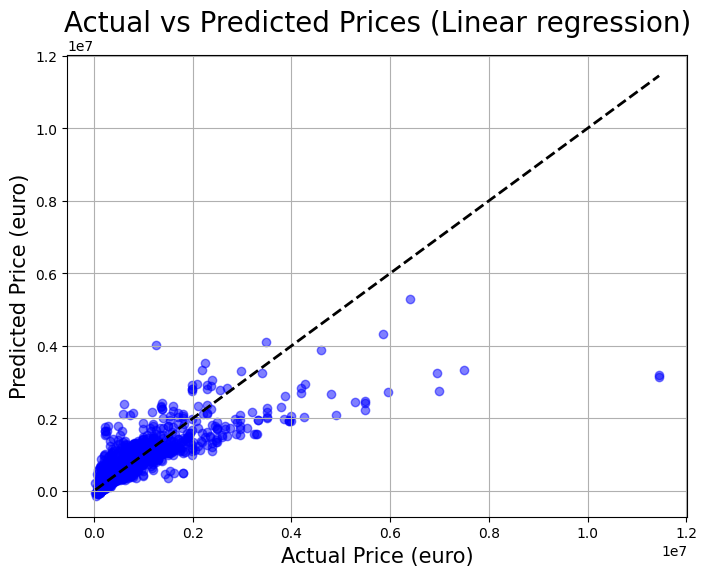

In [ ]:
# VISUALIZE LINEAR REGRESSION
# Scatter plot of actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Price (euro)', fontsize=15)
plt.ylabel('Predicted Price (euro)', fontsize=15)
plt.title('Actual vs Predicted Prices (Linear regression)', fontsize=20)
plt.grid(True)
plt.show()

In [21]:
# DECISION TREE REGRESSOR MODEL
# Build a pipeline including preprocessing and a decision tree regressor model
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', DecisionTreeRegressor())])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predict on the testing set
y_pred = pipeline.predict(X_test)

# Evaluate the model's performance
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("Decision Tree Regressor Model Performance:")
print("R-squared:", r2)
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)

# Extract feature importances from the decision tree regressor model
feature_importance = pipeline.named_steps['regressor'].feature_importances_

# Get feature names from preprocessor
feature_names = pipeline.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out()




Decision Tree Regressor Model Performance:
R-squared: 0.9474549702413189
Mean Absolute Error: 20634.37810321409
Mean Squared Error: 9558030281.242504


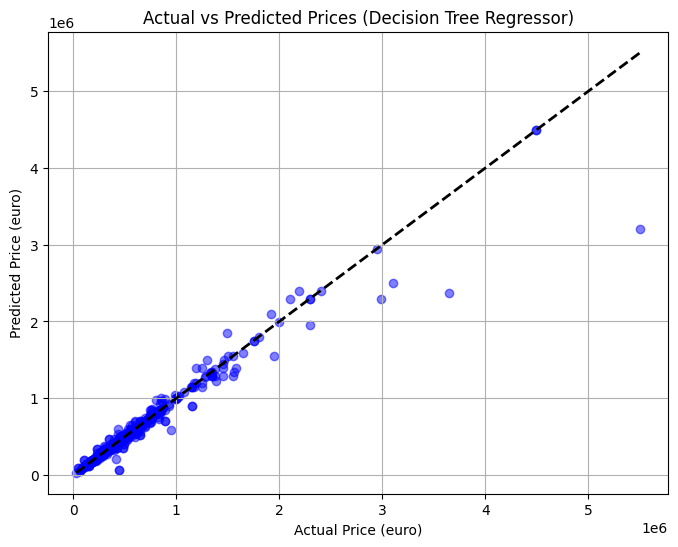

In [22]:
#DECISION TREE OUTPUT VIZ (same as previous graph)
# Scatter plot of actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Price (euro)')
plt.ylabel('Predicted Price (euro)')
plt.title('Actual vs Predicted Prices (Decision Tree Regressor)')
plt.grid(True)
plt.show()


In [27]:

# Build a pipeline including preprocessing and a decision tree regressor model
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', RandomForestRegressor())])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predict on the testing set
y_pred = pipeline.predict(X_test)

# Evaluate the model's performance
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("Decision Tree Regressor Model Performance:")
print("R-squared:", r2)
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)


Decision Tree Regressor Model Performance:
R-squared: 0.9622173340595661
Mean Absolute Error: 13531.683036699762
Mean Squared Error: 6872731195.000867


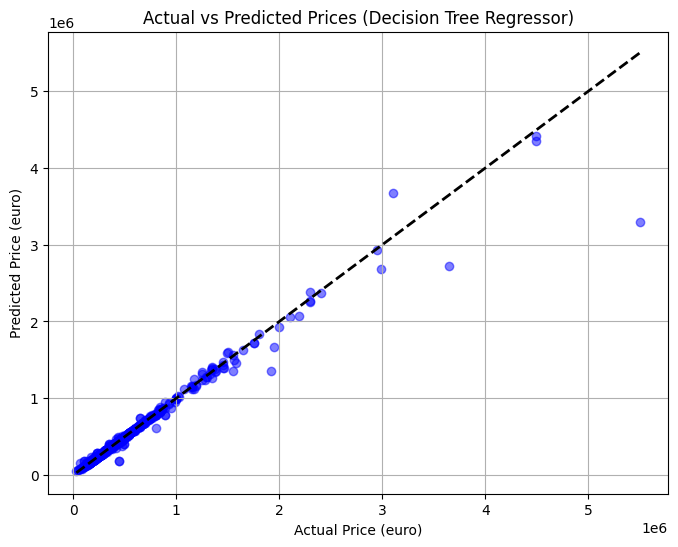

In [28]:
# ANOTER DECISION TREE VIZ
# Scatter plot of actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Price (euro)')
plt.ylabel('Predicted Price (euro)')
plt.title('Actual vs Predicted Prices (Decision Tree Regressor)')
plt.grid(True)
plt.show()





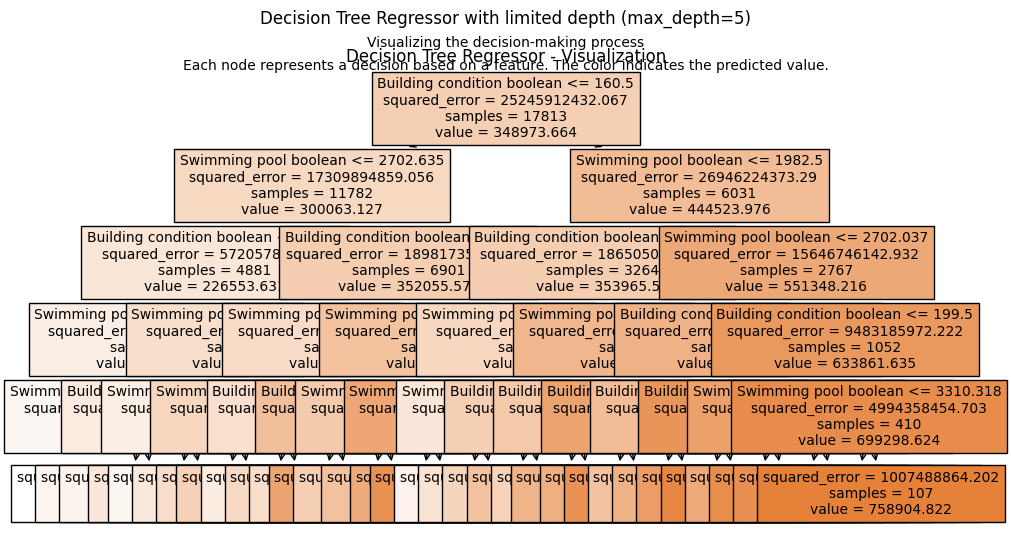

In [ ]:
#DECISION TREE GRAPH
# Create a Decision Tree Regressor with limited depth
regressor = DecisionTreeRegressor(max_depth=5)  # You can adjust the max_depth parameter

# Build a pipeline including preprocessing and the decision tree regressor model
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', regressor)])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Visualize the decision tree
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plot_tree(pipeline.named_steps['regressor'], feature_names=X.columns, filled=True, fontsize=10)  # Adjust font size here

# Add title and axis labels
plt.title('Decision Tree Regressor - Visualization', fontsize=12)  # Adjust title font size
plt.xlabel('Features', fontsize=10)  # Adjust label font size
plt.ylabel('Target', fontsize=10)  # Adjust label font size

# Add explanation text
plt.text(0.5, 1.1, 'Decision Tree Regressor with limited depth (max_depth=5)', horizontalalignment='center', fontsize=12, transform=plt.gca().transAxes)
plt.text(0.5, 1.05, 'Visualizing the decision-making process', horizontalalignment='center', fontsize=10, transform=plt.gca().transAxes)
plt.text(0.5, 1.0, 'Each node represents a decision based on a feature. The color indicates the predicted value.', horizontalalignment='center', fontsize=10, transform=plt.gca().transAxes)

plt.show()
